#  OSFUpload

The goal of this notebook is to :
- Explain how compSPI datasets are stored in OSF.io
- Illustrate retrieval of datasets
- Demonstrate the use of OSFUpload 

Pre Requisites :
- OSF.io account and personal token
- (For Upload) Contributor role on OSF.io project page


## OSF.io

*OSF.io* is a free, open platform maintained by the Centre of Open Science that allows researchers/groups to share data and publish findings. The datasets generated and used by *compSPI* are publically hosted on the "[compSPI datasets](https://osf.io/tj8ya/)" page on OSF.


<!-- 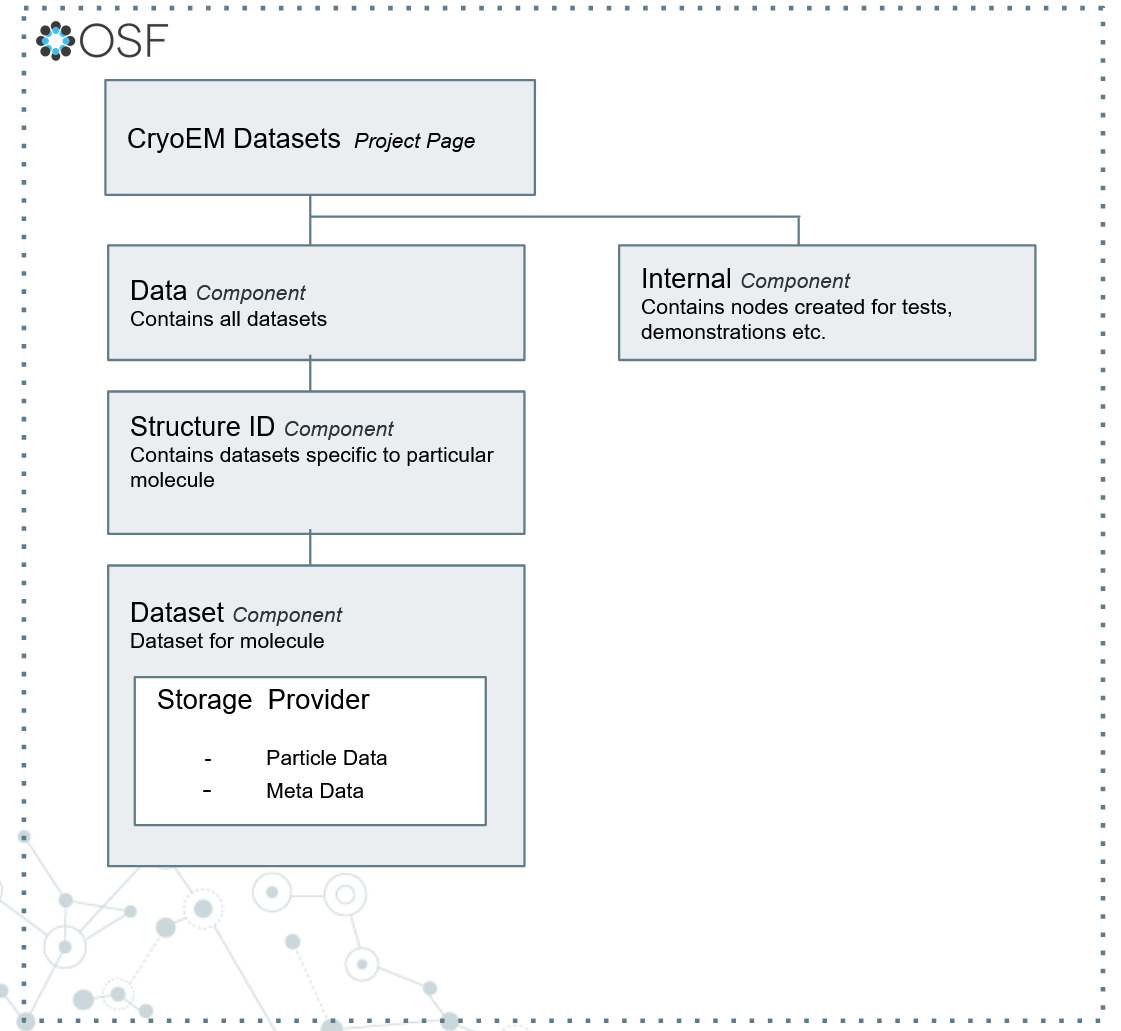 -->
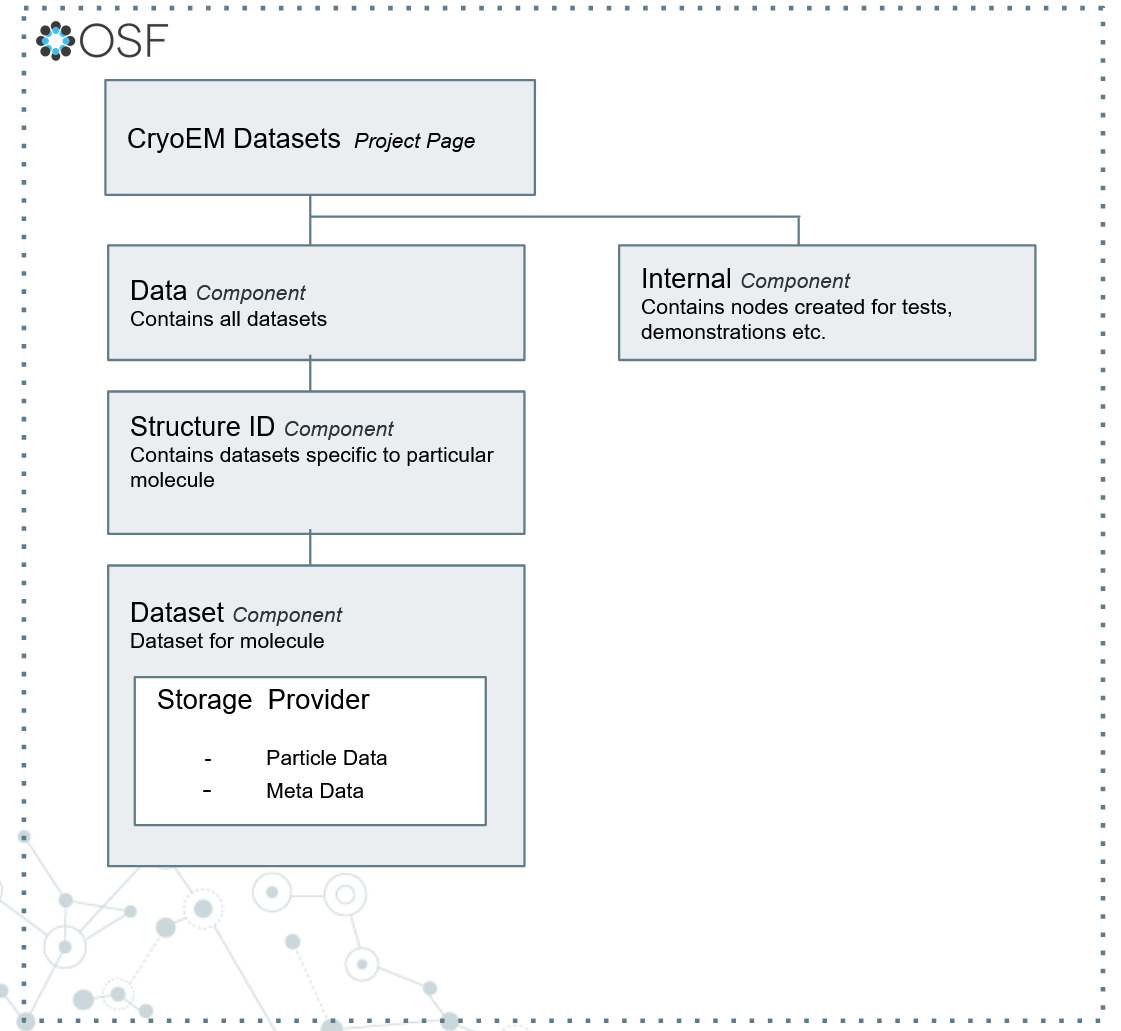

Project Pages on *OSF.io* are structured like a file system. The Project Page/Components (also referred to as *Nodes*) can be thought of as folders, that can contain other folders (i.e components) or files.
The *CryoEM Datasets* project page is organised in the manner shown above where,

- "Data" houses all compSPI strucutral data
- Components labelled as various "Structure IDs" house all data pertaining to a certain structure
- Components under a "Structure ID" correspond to various datasets of the structure. The data/meta-data files can be found at this level.




## Downloading from OSF

### Website

The datasets are publically available and can be accessed directly by navigating to the [compSPI datasets](https://osf.io/24htr/) data page. The various levels of the project page can be navigated through the *OSF.io* user interface as shown below.

<!-- <div>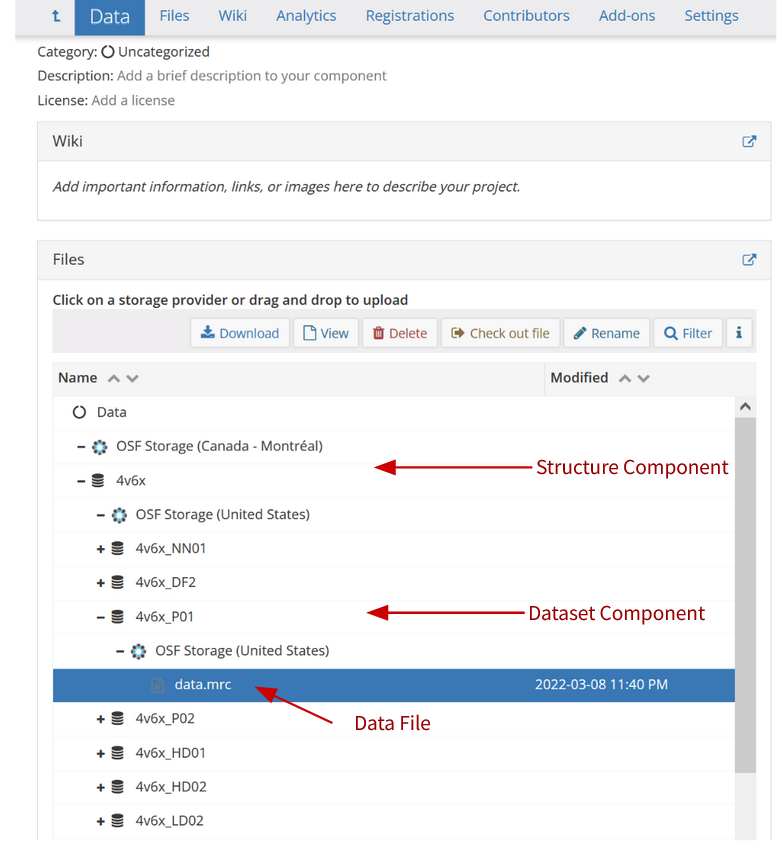</div> -->
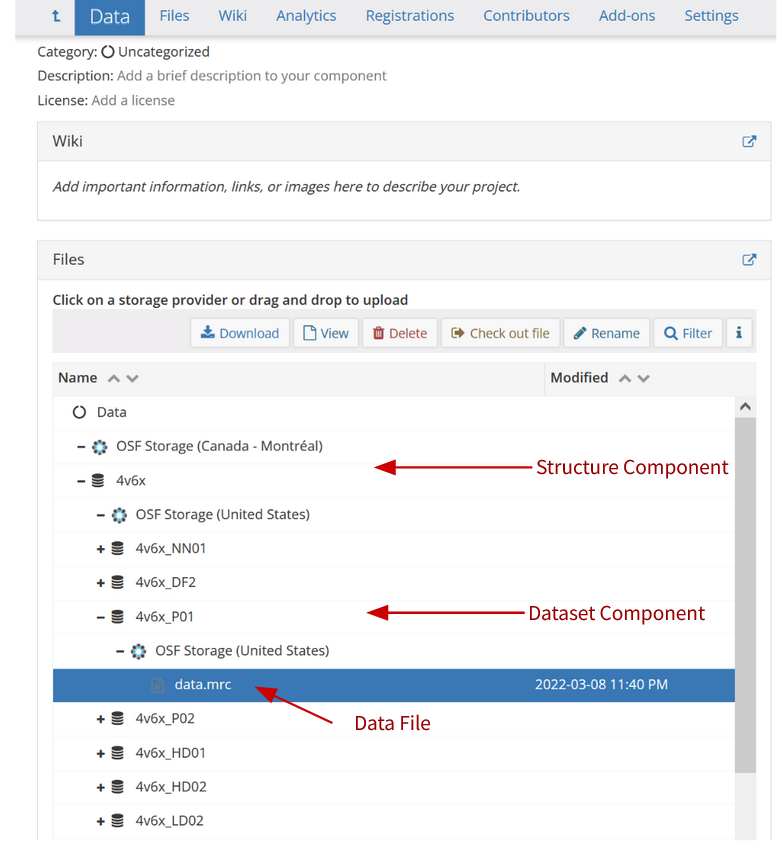

The dataset components are labelled with tags that provide a high level overview of their charecteristics. The tags can be seen by navigating to one of the dataset components on the right.

The OSF search feature can be used to quickly filter through and retrieve the datasets. The search queries are constructed using the [Lucene Search Syntax]("https://extensions.xwiki.org/xwiki/bin/view/Extension/Search+Application+Query+Syntax#HSearchingforfieldsinXWikiobjects"). 

For compSPI datasets, all datasets corresponding to a certain structure can retrieved using the syntax : <code>title:structure_name\*</code>. For example, <code>title:4v6x\*</code>. would retrieve all nodes with "4v6x" in their title.

Further, datasets can be narrowed by tags. compSPI datasets tags follow the convent *tag_name:tag_value*. For example, <code>noise_type:gaussian</code> or <code>pixel_size_um:1</code>. To use tags in the search use the following syntax <code>tags:("tag_name:tag_value")</code>.

An example of a search query retrieving all datasets for the 4v6x structure with rotation_distribution as uniform_on_sphere would be <code>title:4v6x*  AND tags:("rotation_distribution:uniform_on_sphere")</code>

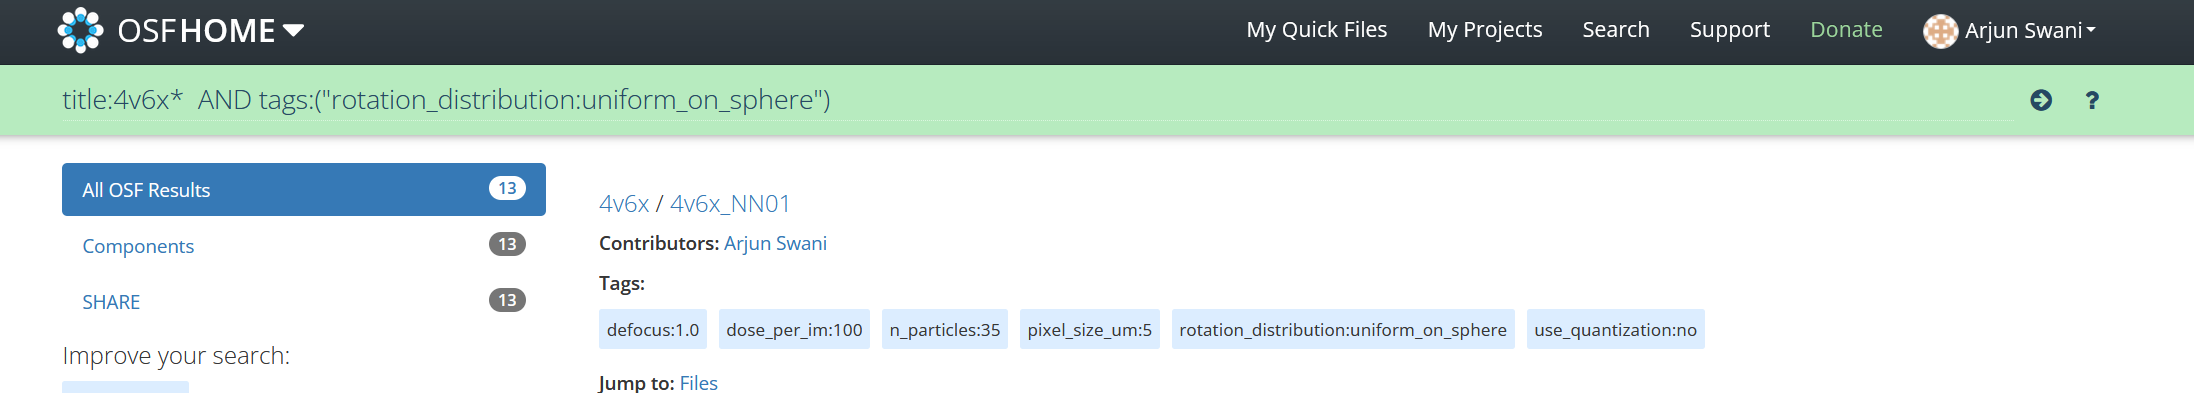

### API

Nodes and files hosted on *OSF.io* can be accessed using the [OSF API](https://developer.osf.io/). An OSF account and token (generation demonstrated in API docs) are required to use the API. 
Note that each node is identified by a unique ID. The ID for the Data node on the CompSPI project page is *24htr*.

The OSF API is incredibly powerful and well documented. Some examples in the context of the CompSPI datasets are given below.

In [44]:
import requests
token = "Ae5oInJGTYvhqP0aaYSdwl08yjBWpyXlQsYC3pd6wDLJGlKVgekRu6fZZwpodu23Z3ad0x" # API Token goes here
    

In [50]:
# get all children under a node (data in this instance)
def get_child_nodes_under_data():

    request_url = "https://api.osf.io/v2/nodes/24htr/children"
    request_headers = {"Authorization": f"Bearer {token}"}
    
    
    response = requests.get(request_url, headers=request_headers)
    response.raise_for_status()
    
    return response.json()["data"]
    
response_data = get_child_nodes_under_data()

# print first child's title and id

print(response_data[0]["attributes"]["title"])
print(response_data[0]["id"])

4v6x
grzkb


In [64]:
# Retrieve node with title and downlaod stored file
def download_data(title):
    request_url = f"https://api.osf.io/v2/nodes/?filter[title]={title}"
    request_headers = {"Authorization": f"Bearer {token}"}
    
    
    response = requests.get(request_url, headers=request_headers)
    response.raise_for_status()
    
    node_id = response.json()["data"][0]["id"]
    
    
    file_request_url =  f"https://api.osf.io/v2/nodes/{node_id}/files/osfstorage"
    response = requests.get(file_request_url, headers=request_headers)
    response.raise_for_status()
    download_link = response.json()["data"][0]["links"]["download"]
    
    return requests.get(download_link).text

download_data("download_demo_compspi")

'Demo for osf download'

## Uploading from OSF

In [19]:
from ioSPI.datasets import OSFUpload

In [20]:
token = "Ae5oInJGTYvhqP0aaYSdwl08yjBWpyXlQsYC3pd6wDLJGlKVgekRu6fZZwpodu23Z3ad0x" # insert OSF token here
internal_node = "9jwpu"

In [21]:
osf = OSFUpload(token,internal_node)

In [35]:
osf.read_existing_structure_labels()

{'notebook_demo': '3n8dv',
 'test_xjcdl': 'm73ac',
 'test_viHVr': 'j2d9q',
 'test_hzQqZ': 'b37tv',
 'test_ZEbyu': '7ef2v',
 'test_XgNfh': '4k75c',
 'test_XvWeZ': 'z4nsq',
 'test_LXnPb': 'ytcwv',
 'test_yXXoP': 'njbfy'}

In [36]:
returned_guid = osf.read_structure_guid('Non-Existent_Label') 
print(returned_guid)


None


In [38]:
structure_guid = osf.read_structure_guid('notebook_demo') 
print(structure_guid)

3n8dv


In [39]:
dataset_guid = osf.write_child_node(structure_guid,"no_noise",["tag_a:value","tag_b:value","tag_c:value"])
print(dataset_guid)

qdzsc


In [40]:
def make_file(filename):
    with open(filename, 'w') as f:
        f.write('Sample file containing particle map or meta-data!')
    return filename

upload_files = []
upload_files.append(make_file('sample_data.txt'))

success = osf.write_files(dataset_guid,upload_files)

print(success)

Uploaded sample_data.txt 
True


In [41]:
# Deletes files and nodes created in this notebook

import os
import requests

if os.path.exists("sample_data.txt"):
  os.remove("sample_data.txt")

def cleanup(node_guid, test_node_label):
    """Recursively delete nodes and subcomponents."""
    base_api_url = "https://api.osf.io/v2/nodes/"
    base_node_url = f"{base_api_url}{node_guid}/"
    request_headers = {"Authorization": f"Bearer {token}"}
    
    
    response = requests.get(f"{base_node_url}children/", headers=request_headers)
    response.raise_for_status()

    for node_child in response.json()["data"]:
        cleanup(node_child["id"], node_child["attributes"]["title"])

    response = requests.delete(base_node_url, headers=request_headers)

    if not response.ok:
        print(
            f"Failure: {test_node_label} could not be"
            f" deleted due to error code {response.status_code}."
        )
        print(response.json()["errors"][0]["detail"])
    else:
        print(f"Success: {test_node_label} deleted")
cleanup(dataset_guid,'no_noise')

Success: no_noise deleted
